In [1]:
!pip install transformers torch pandas scikit-learn numpy matplotlib seaborn xgboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# ================================================
# Improved FinBERT + XGBoost for Stock Movement
# ================================================
# pip install xgboost pandas numpy matplotlib seaborn scikit-learn joblib tqdm transformers ta

import warnings, joblib
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from tqdm import tqdm

# ========== Load ==========
df = pd.read_csv("data/processed/merged_clean.csv")
target_col = "movement"

if target_col not in df.columns:
    raise ValueError("No 'movement' column found.")

# Sentiment placeholders if absent
for col in ["sent_pos","sent_neu","sent_neg"]:
    if col not in df.columns: df[col] = 0.0


In [11]:
# ========== Basic preprocessing ==========
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')

# Compute returns if not already present
if 'return' not in df.columns:
    price_col = 'close' if 'close' in df.columns else df.columns[1]
    df['return'] = df[price_col].pct_change()

# ========== Feature Engineering ==========
# Lags
for l in [1,2,3,5,10]:
    df[f'ret_lag_{l}'] = df['return'].shift(l)

# Rolling stats
for w in [3,7,14]:
    df[f'ret_roll_mean_{w}'] = df['return'].rolling(w).mean()
    df[f'ret_roll_std_{w}'] = df['return'].rolling(w).std()

# Technical indicators
rsi = RSIIndicator(df['close'], window=14).rsi()
macd = MACD(df['close']).macd_diff()
bb = BollingerBands(df['close'], window=20)
df['rsi'] = rsi
df['macd'] = macd
df['bb_high'] = bb.bollinger_hband()
df['bb_low']  = bb.bollinger_lband()
df['bb_width'] = df['bb_high'] - df['bb_low']

# Sentiment deltas
df['sent_pos_diff'] = df['sent_pos'].diff()
df['sent_score'] = df['sent_pos'] - df['sent_neg']

# Drop missing
df = df.dropna().reset_index(drop=True)

# Feature selection
feature_cols = [c for c in df.columns if c not in ['date','ticker',target_col]]
X = df[feature_cols].values
y = df[target_col].values

In [ ]:
# ========== Grid Search (no early stopping inside GridSearchCV) ==========
grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Fit grid search normally
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

# ========== Retrain best model with early stopping ==========
best_params = grid.best_params_
best = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    tree_method='hist',
    n_jobs=-1,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
)

best.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=30,
    verbose=False
)

joblib.dump(best, "finbert_xgb_improved.joblib")
print("✅ Retrained best model with early stopping and saved.")


Fitting 4 folds for each of 1458 candidates, totalling 5832 fits


In [ ]:
# ========== Evaluation ==========
y_prob = best.predict_proba(X_test)[:,1]
y_pred = (y_prob>0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print(f"\nAccuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

After feature engineering, rows: 190782


In [ ]:
# ========== Visualization ==========
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Improved XGBoost)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# ROC
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
fpr,tpr,_=roc_curve(y_test,y_prob)
plt.plot(fpr,tpr,label=f"AUC={roc:.3f}",linewidth=2)
plt.plot([0,1],[0,1],'--',color='red')
plt.title("ROC Curve (Improved Model)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True,ls='--',alpha=0.6); plt.show()

# PR Curve
precision, recall,_=precision_recall_curve(y_test,y_prob)
ap=average_precision_score(y_test,y_prob)
plt.plot(recall,precision,label=f"AP={ap:.3f}",linewidth=2)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve"); plt.legend(); plt.grid(True,ls='--',alpha=0.6)
plt.show()

# Feature Importance
plt.figure(figsize=(8,6))
xgb.plot_importance(best, importance_type='gain', max_num_features=20)
plt.title("Top Feature Importances (XGBoost + FinBERT)")
plt.show()

print("Model & scaler saved ✅")

['xgb_scaler.joblib']

In [6]:
# -----------------------
# 5) XGBoost training with TimeSeriesSplit CV
# -----------------------
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42, n_jobs=-1)

# small hyperparameter grid to speed up; enlarge for more tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=4)
gsearch = GridSearchCV(xgb_clf, param_grid, cv=tscv, scoring='roc_auc', verbose=1, n_jobs=-1)
gsearch.fit(X_train_scaled, y_train)

print("Best params:", gsearch.best_params_)
best_xgb = gsearch.best_estimator_

# save model
joblib.dump(best_xgb, "xgb_finbert_model.joblib")

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}


['xgb_finbert_model.joblib']

In [7]:
# -----------------------
# 6) Evaluation on test set
# -----------------------
y_prob = best_xgb.predict_proba(X_test_scaled)[:,1]
y_pred = best_xgb.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

print("\nTest metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")
print(f"PR AUC (Average Precision): {ap:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Test metrics:
Accuracy: 0.5056
F1 score: 0.4804
ROC AUC: 0.5098
PR AUC (Average Precision): 0.5214

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.57      0.53     18641
           1       0.52      0.45      0.48     19516

    accuracy                           0.51     38157
   macro avg       0.51      0.51      0.50     38157
weighted avg       0.51      0.51      0.50     38157



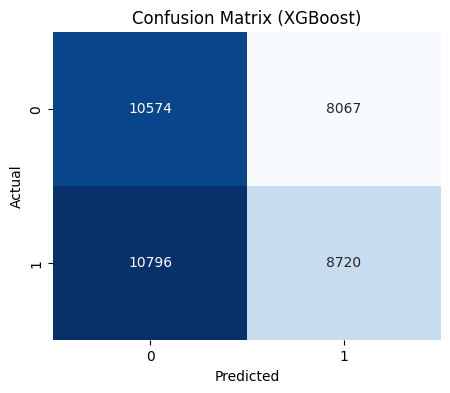

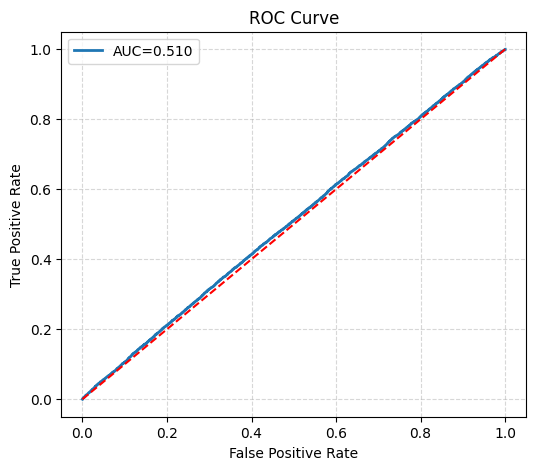

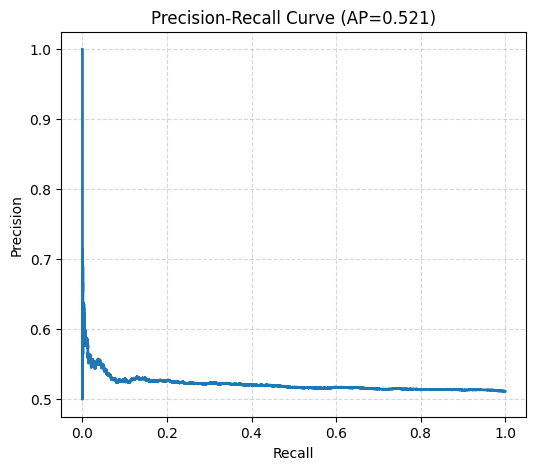

<Figure size 800x600 with 0 Axes>

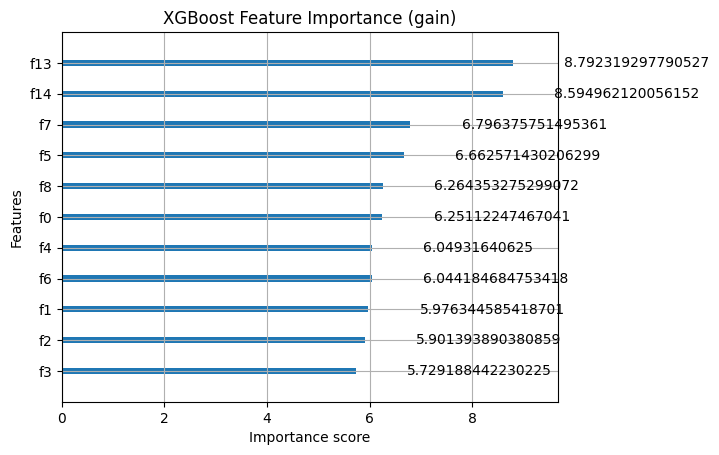

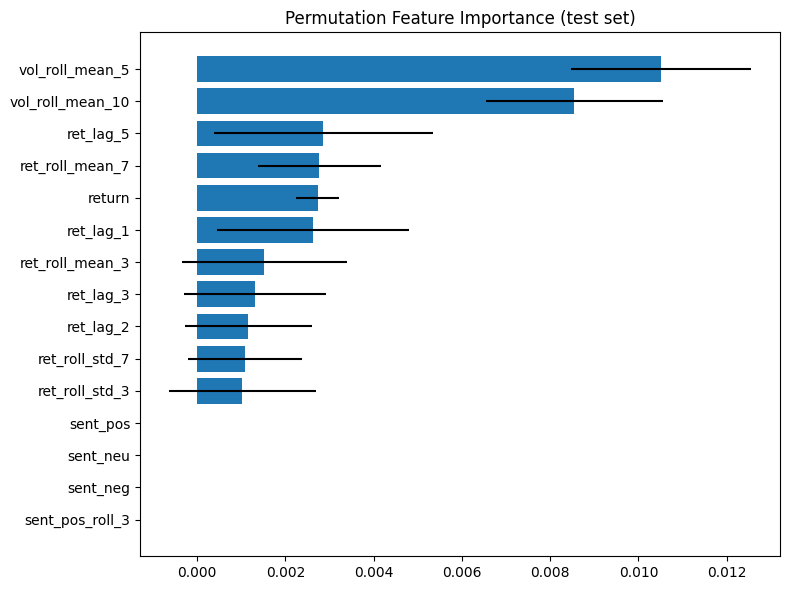

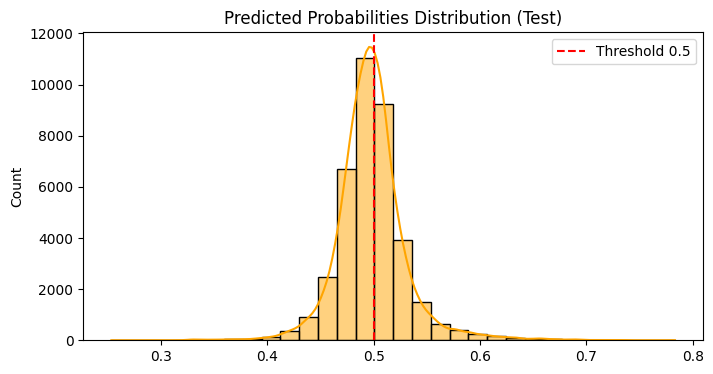

Saved model: xgb_finbert_model.joblib and scaler: xgb_scaler.joblib


In [8]:
# -----------------------
# 7) Plots — Confusion Matrix, ROC, PR, Feature Importance
# -----------------------
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc:.3f}", linewidth=2)
plt.plot([0,1],[0,1],'--', color='red')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision-Recall Curve (AP={ap:.3f})")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Feature importance (gain)
plt.figure(figsize=(8,6))
xgb.plot_importance(best_xgb, importance_type='gain', max_num_features=20)
plt.title("XGBoost Feature Importance (gain)")
plt.show()

# Optional: permutation importance (slower but model-agnostic)
from sklearn.inspection import permutation_importance
perm = permutation_importance(best_xgb, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_idx = np.argsort(perm.importances_mean)[::-1][:20]
plt.figure(figsize=(8,6))
plt.barh(range(len(perm_idx)), perm.importances_mean[perm_idx][::-1], xerr=perm.importances_std[perm_idx][::-1])
plt.yticks(range(len(perm_idx)), [feature_cols[i] for i in perm_idx][::-1])
plt.title("Permutation Feature Importance (test set)")
plt.tight_layout()
plt.show()

# -----------------------
# 8) Additional insights: calibration & probabilities distribution
# -----------------------
plt.figure(figsize=(8,4))
sns.histplot(y_prob, bins=30, kde=True, color='orange')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.title("Predicted Probabilities Distribution (Test)")
plt.legend(); plt.show()

# Calibration (optional) — requires sklearn.calibration if desired

print("Saved model: xgb_finbert_model.joblib and scaler: xgb_scaler.joblib")
# ============================ END =================================